# Experiments on Quantile Recalibration Training

## 0. Imports

In [3]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import torch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import fonts

from uq.analysis.dataframes import (
	load_config, load_df, make_test_df_for_tuning, get_datasets_df, get_duplication_df,
	set_hparams_columns, make_df_abb
)
from uq.analysis.plot_metrics import make_plot_df, plot_metric_comparison_per_epoch
from uq.analysis.plot_cohen_d import build_cohen_d
from uq.analysis.plot_reliability_diagrams import plot_reliability_diagrams, make_reliability_df
from uq.analysis.plot_predictions import plot_predictions
from uq.analysis.queries import disjunction
from uq.utils.general import filter_dict, set_notebook_options, savefig, op_without_index
from uq.analysis.constants import ext, main_metrics, other_metrics, metric_names, cat_cmap
from uq.analysis.helpers import standard_setting, preprocess, plot_all_cohen_d, filter_df, add_name_index, latex_names

set_notebook_options()
np.seterr(invalid='ignore')

path = Path('results')

# LaTeX fonts (requires more time to create figures)
plt.rcParams.update(fonts.aistats2023_tex())

## 1. hyperparams tuning for Boston 

In [2]:
import pprint
import matplotlib.pyplot as plt

# Disable LaTeX rendering
plt.rcParams['text.usetex'] = False
config = load_config('logs/per_epoch')
reload_df = True
df = load_df(config, tuning=True) if reload_df else None
title = "QRT Per Epoch Results w/ Our Model For Boston Housing Dataset"
# test_df = make_test_df_for_tuning(df, config)
# test_df = preprocess(test_df)


print("Shape of the DataFrame:")
print(df.shape, "\n")

# print("DataFrame Info:")
# print(df.info(), "\n")

unique_keys = set()

for i in range(df.shape[0]):
    unique_keys = unique_keys.union(df['hparams'].iloc[i].keys())
# print(len(unique_keys), unique_keys)

# print("Summary Statistics (Numerical Columns):")
# print(df.describe(), "\n")

ECE_KEY = "calib_l1"
SHARPNESS_KEY = "sharpness"
MODES = ['train', 'val', 'test']
METRICS_MAPPING = {
    'ece': ECE_KEY,
    'sharpness': SHARPNESS_KEY
}
COLORS = {
    'train': 'light',
    'val': 'dark',
    'test': 'light',
    'ece': 'blue',
    'sharpness': 'green'
}


metrics_for_one_run = df['metrics'].iloc[0]
best_epoch = int(metrics_for_one_run['best_iter'])

plt.figure(figsize=(8, 6))

if df.shape[0] == 1:
    fig, axes = plt.subplots(1, 1, figsize=(6, 5))
    axes = [axes]
else:
    fig, axes = plt.subplots(df.shape[0] // 3, 3, figsize=(20, df.shape[0] // 3* 5))
    axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx >= len(df):
        ax.axis('off')
        continue

    metrics_for_one_run = df['metrics'].iloc[idx]
    best_epoch = int(metrics_for_one_run['best_iter'])
    
    
    max_epoch = 10
    ax.axvline(x=best_epoch, color='r', linestyle='--', label='best epoch')

    for mode in MODES:
        for metric_name, _metric_key in METRICS_MAPPING.items():
            metric_key = f'{mode}_{_metric_key}'
            metric_label = f'{mode} {metric_name}'
            metric_values = list(metrics_for_one_run["per_epoch"][metric_key].values())
            epochs = list(metrics_for_one_run["per_epoch"][metric_key].keys())
            color = COLORS[mode] + COLORS[metric_name]
            max_epoch = max(max_epoch, len(epochs))
            if mode == 'test':
                ax.scatter(epochs, metric_values, label=metric_label, color=color)
            else:
                # print(len(epochs), len(metric_values))
                ax.plot(epochs, metric_values, label=metric_label, color=color)
    ax.set_xlim(0, max_epoch + 1)

    hparams_str = f'exp_{idx}:\n'
    for k in unique_keys:
        v = df['hparams'].iloc[idx][k] if k in df['hparams'].iloc[idx] else "None"
        hparams_str += f'{k}={v}\n'

    ax.annotate(f'{hparams_str}', (1, 0.2), textcoords="offset points", 
                ha='left', fontsize=6)
    ax.set_xlabel(f'Epochs (Best Epoch: {best_epoch}, Val loss: {metrics_for_one_run["best_score"]:.2f} Val ECE: {metrics_for_one_run["per_epoch"]["val_calib_l1"][best_epoch]:.2f}, Val Sharpness: {metrics_for_one_run["per_epoch"]["val_sharpness"][best_epoch]:.2f})')
    ax.set_title(f'ECE and Sharpness over Epochs for Run {idx}')
    ax.legend(loc='upper right')

plt.tight_layout()
fig.suptitle(title, fontsize=16, y=1.02)
plt.show()


# pprint.pprint(df['hparams'].iloc[0])
# 
for i in range(df.shape[0]):
    print(f"Run {i}:")
    pprint.pprint(df['hparams'].iloc[i])
    print()
# print(df['metrics'].iloc[0])
# print(df['config'].iloc[0])

# print("head of the DataFrame:")
# print(df.head(), "\n")




FileNotFoundError: [Errno 2] No such file or directory: 'logs/per_epoch/config.yaml'

## 2. Random Seeds Plots

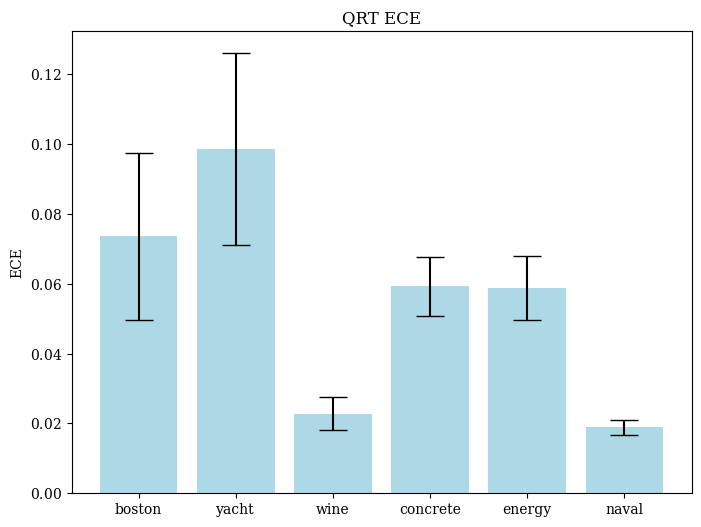

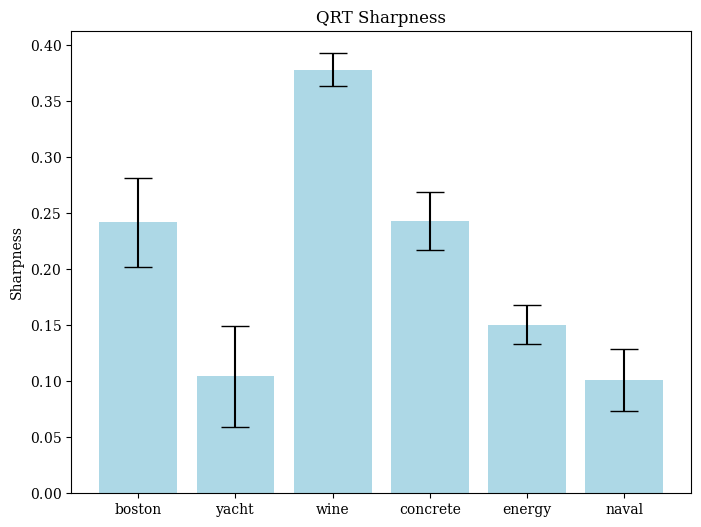

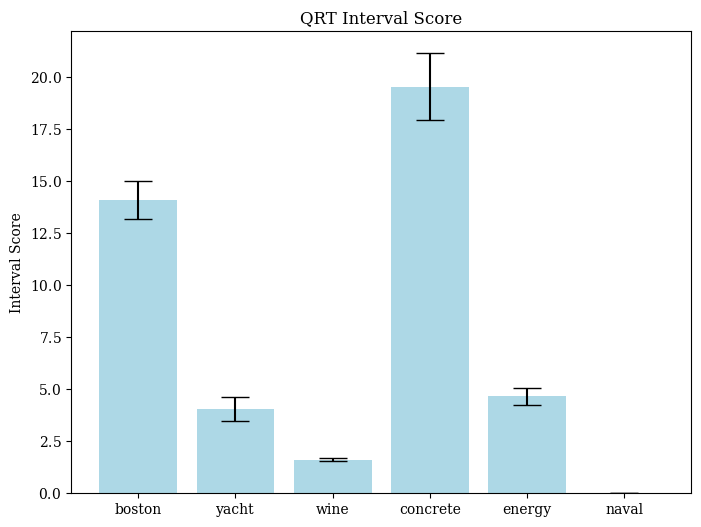

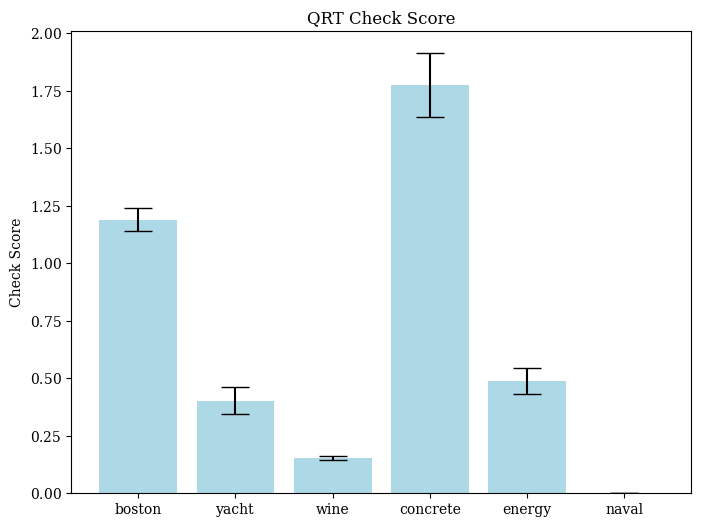

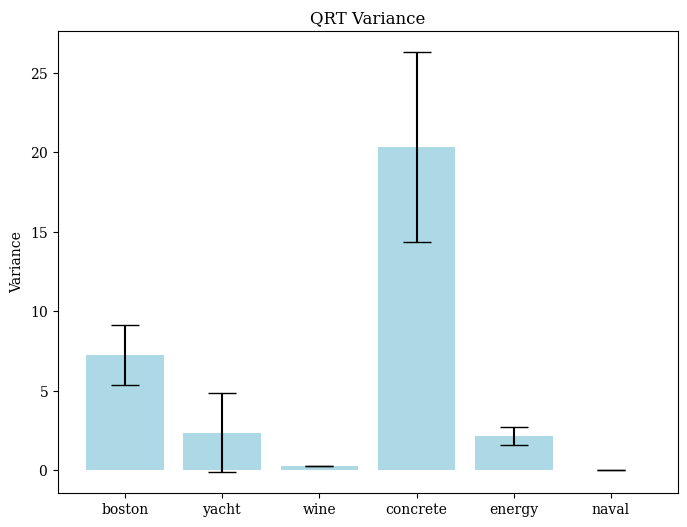

In [9]:
import pprint
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['text.usetex'] = False
show_plot_details = False #@param {type:"boolean"}
plot_table = False #@param {type:"boolean"}
plot_bar_graph = True #@param {type:"boolean"}


datasets = ['boston', 'yacht', 'wine', 'concrete', 'energy', 'naval']
dataset_name = 'yacht'
title = "QRT Results"
ECE_KEY = "calib_l1"
SHARPNESS_KEY = "sharpness"
MODES = ['train', 'val', 'test']
METRICS_MAPPING = {
    'ece': ECE_KEY,
    'sharpness': SHARPNESS_KEY
}
COLORS = {
    'train': 'light',
    'val': 'dark',
    'test': 'light',
    'ece': 'blue',
    'sharpness': 'green'
}

EVAL_KEYS = {
    'ECE': f'test_{ECE_KEY}',
    'Sharpness': f'test_{SHARPNESS_KEY}',
    'Interval Score': f'test_interval_score',
    'Check Score': f'test_check_score',
    'Variance': f'test_variance'
}

if show_plot_details:

    plt.figure(figsize=(8, 6))
    fig, axes = plt.subplots(len(datasets), 5, figsize=(25, 5 * len(datasets)))

    for dataset_index, dataset_name in enumerate(datasets):
        ax = axes[dataset_index][0].set_ylabel(f'{dataset_name}')
        for seed_index in range(1, 6):
            ax = axes[dataset_index][seed_index - 1]
            config = load_config(f'logs/{dataset_name}_{seed_index}')
            reload_df = True
            df = load_df(config, tuning=True) if reload_df else None

            unique_keys = set()
            for i in range(df.shape[0]):
                unique_keys = unique_keys.union(df['hparams'].iloc[i].keys())

            metrics_for_one_run = df['metrics'].iloc[0]
            best_epoch = int(metrics_for_one_run['best_iter'])

            for mode in MODES:
                for metric_name, _metric_key in METRICS_MAPPING.items():
                    metric_key = f'{mode}_{_metric_key}'
                    metric_label = f'{mode} {metric_name}'
                    metric_values = list(metrics_for_one_run["per_epoch"][metric_key].values())
                    epochs = list(metrics_for_one_run["per_epoch"][metric_key].keys())
                    color = COLORS[mode] + COLORS[metric_name]
                    # max_epoch = max(max_epoch, len(epochs))
                    if mode == 'test':
                        ax.scatter(epochs, metric_values, label=metric_label, color=color)
                    else:
                        # print(len(epochs), len(metric_values))
                        ax.plot(epochs, metric_values, label=metric_label, color=color)
            # ax.set_xlim(0, max_epoch + 1)

            ax.set_xlabel(f'Epochs (Best Epoch: {best_epoch}, Val loss: {metrics_for_one_run["best_score"]:.2f} Val ECE: {metrics_for_one_run["per_epoch"]["val_calib_l1"][best_epoch]:.2f}, Val Sharpness: {metrics_for_one_run["per_epoch"]["val_sharpness"][best_epoch]:.2f})', fontsize=8)
            ax.set_title(f'Seed {seed_index}')
            ax.legend(loc='upper right')

    plt.tight_layout()
    fig.suptitle(title, fontsize=12, y=1.02)
    plt.show()


# plot the mean and std of the ECE and sharpness over the 5 seeds 
# Collect metrics for each seed


metrics = {}
for dataset_index, dataset_name in enumerate(datasets):
    test_ece_list = []
    test_sharpness_list = []
    metrics[dataset_name] = {}
    for seed_index in range(1, 6):
        config = load_config(f'logs/{dataset_name}_{seed_index}')
        reload_df = True
        df = load_df(config, tuning=True)
        metrics_for_one_run = df['metrics'].iloc[0]
        best_epoch = int(metrics_for_one_run['best_iter'])
        for metric_name, metric_key in EVAL_KEYS.items():
            test_metric = list(metrics_for_one_run["per_epoch"][metric_key].values())[0]
            if not metric_name in metrics[dataset_name].keys():
                metrics[dataset_name][metric_name] = []
            metrics[dataset_name][metric_name].append(test_metric)

# pprint.pprint(metrics)

if plot_bar_graph:
    for metric_name, metric_key in EVAL_KEYS.items():
        fig, ax = plt.subplots(figsize=(8, 6))
        means = [np.mean(metrics[dataset][metric_name]) for dataset in datasets]
        # print(metric_name, metrics['concrete'])
        stds = [np.std(metrics[dataset][metric_name]) for dataset in datasets]
        ax.bar(datasets, means, yerr=stds, capsize=10, color=['lightblue'])

        ax.set_ylabel(metric_name)
        ax.set_title(f'QRT {metric_name}')
        plt.show()

if plot_table:
    metrics_summary = {dataset: {} for dataset in datasets}
    for dataset in datasets:
        for metric_name in EVAL_KEYS.keys():
            mean_value = np.mean(metrics[dataset][metric_name])
            std_value = np.std(metrics[dataset][metric_name])
            metrics_summary[dataset][metric_name] = f'{mean_value:.4f} ± {std_value:.4f}'

    # Convert the dictionary to a DataFrame
    metrics_summary_df = pd.DataFrame(metrics_summary).T

    # Display the DataFrame as a table
    display(metrics_summary_df)

    # Plot a table with the mean and std of the ECE and sharpness over the 5 seeds
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    table_data = metrics_summary_df.reset_index().values.tolist()
    table = ax.table(cellText=table_data, colLabels=metrics_summary_df.columns.insert(0, 'Dataset'), cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.show()



### Comparison of some methods against a baseline

In [89]:
def plot_some(name, mixture_size=[3], cal_size=[2048], base_model='nn', **kwargs):
    baseline_query = ('regul.isna() '
        'and inhoc_method.isna() and inhoc_dataset == "batch" '
        'and posthoc_method.isna() and posthoc_dataset == "train"'
    )
    join_by = []

    plot_df = filter_df(test_df, mixture_size=mixture_size, cal_size=cal_size, base_model=base_model)
    queries = [
        baseline_query,
        'base_loss == "nll_inhoc_mc" and inhoc_method in ["QRT", "QREG"] and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
        'inhoc_method.isna() and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    ]
    plot_df = plot_df.query(disjunction(queries))

    names = [r'\textbf{QRTC}', 'QRC', 'QREGC']
    cmap_cohen = dict(zip(names, cat_cmap))
    cmap_diff = dict(zip(names[:2], cat_cmap))

    plot_all_cohen_d(
        config, name, plot_df, baseline_query, join_by, path,
        cohen_kwargs={'cmap': cmap_cohen},
        cd_kwargs=None,
        diff_kwargs={'cmap': cmap_diff},
        **kwargs
    )
    return plot_df

plot_df_some = plot_some('some')

Plotting some


ValueError: No baseline found

In [7]:
plot_some('some_mixture_1', mixture_size=[1])
plot_some('some_mixture_10', mixture_size=[10])
plot_df_some_mixture_3_resnet = plot_some('some_mixture_3_resnet', base_model='resnet');

Plotting some_mixture_1


ValueError: No baseline found

### Comparison of variants against no variant

In [8]:
def plot_variants(name, **kwargs):
    baseline_query = ('regul.isna() '
        'and inhoc_method.isna() and inhoc_dataset == "batch" '
        'and posthoc_method.isna() and posthoc_dataset == "calib"'
    )
    join_by = []

    plot_df = filter_df(test_df, no_inhoc_variant=False)
    queries = [
        baseline_query,
        'base_loss == "nll_inhoc_mc" and inhoc_method == "QRT" and inhoc_dataset == "batch" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    ]
    plot_df = plot_df.query(disjunction(queries))

    cmap = {
        r'\textbf{QRTC}': cat_cmap[0],
        'QRIC': cat_cmap[3],
        'QRGC': cat_cmap[4],
        'QRLC': cat_cmap[5],
    }

    plot_all_cohen_d(config, name, plot_df, baseline_query, join_by, path, cmap=cmap,
        **kwargs
    )

plot_variants('inhoc_variants')

Plotting inhoc_variants
Size of groups: 4 of size 1


RuntimeError: Failed to process string with tex because latex could not be found

Error in callback <function _draw_all_if_interactive at 0x7f47b1631080> (for post_execute), with arguments args (),kwargs {}:


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2400x285 with 4 Axes>

### Comparison of base models

In [ ]:
def plot_base_models(name, **kwargs):
    baseline_query = ('regul.isna() '
        'and inhoc_method.isna() and inhoc_dataset == "batch" '
        'and posthoc_method.isna() and posthoc_dataset == "train" and mixture_size == 3 and base_model == "nn" '
    )
    join_by = []

    plot_df = filter_df(test_df, base_model=None, mixture_size=None)
    queries = [
        baseline_query,
        'base_loss == "nll_inhoc_mc" and inhoc_method == "QRT" and inhoc_dataset == "batch" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    ]
    plot_df = plot_df.query(disjunction(queries))

    

    plot_all_cohen_d(
        config, name, plot_df, baseline_query, join_by, path,
        add_base_model=True, add_mixture_size=True,
        cohen_kwargs={'wspace': 0.85},
        cd_kwargs={'textspace': 0.85},
        **kwargs
    )

plot_base_models('base_models')

### Comparison of inhoc_cal_size

In [ ]:
def plot_cal_size(name, **kwargs):
    baseline_query = ('regul.isna() '
        'and inhoc_method.isna() and inhoc_dataset == "batch" '
        'and posthoc_method.isna() and posthoc_dataset == "train"'
    )
    join_by = []

    plot_df = filter_df(test_df, inhoc_cal_size=None, inhoc_dataset=None)
    queries = [
        baseline_query,
        'cal_size == 2048 and base_loss == "nll_inhoc_mc" and inhoc_method == "QRT" and inhoc_dataset == "batch" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
        'not inhoc_cal_size.isna() and base_loss == "nll_inhoc_mc" and inhoc_method == "QRT" and inhoc_dataset == "train" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    ]
    plot_df = plot_df.query(disjunction(queries))

    plot_all_cohen_d(
        config, name, plot_df, baseline_query, join_by, path, 
        only_inhoc_cal_size=True,
        cohen_kwargs={'wspace': 0.58},
        diff_kwargs={},
        cd_kwargs={'textspace': 0.75},
        cmap='inhoc_cal_size',
        **kwargs
    )

plot_cal_size('inhoc_cal_size')

### Unbounded vs Truncated vs Reflected

In [ ]:
def plot_reflected(name, **kwargs):
    baseline_query = ('regul.isna() '
        'and inhoc_method.isna() and inhoc_dataset == "batch" '
        'and posthoc_method.isna() and posthoc_dataset == "train"'
    )
    join_by = []

    plot_df = filter_df(test_df, only_posthoc_reflected=False, cal_size=[2047, 2048])
    queries = [
        baseline_query,
        'base_loss == "nll_inhoc_mc" and inhoc_method == "QRT" and inhoc_dataset == "batch" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    ]
    plot_df = plot_df.query(disjunction(queries))

    cmap = {
        'QRTC-REFL': cat_cmap[0],
        'QRTC-TRUNC': cat_cmap[3],
        'QRTC-KDE': cat_cmap[4],
    }

    plot_all_cohen_d(
        config, name, plot_df, baseline_query, join_by, path, 
        only_posthoc_reflected=True,
        main_metrics=['test_nll', 'test_calib_l1'],
        cohen_kwargs={'wspace': 0.65},
        cd_kwargs={'textspace': 0.75},
        cmap=cmap,
        **kwargs
    )

plot_reflected('reflected')

### Comparison of inhoc_alpha

In [ ]:
def plot_inhoc_alpha(name, **kwargs):
    # Note: the baseline has the posthoc_method set to smooth_ecdf
    baseline_query = ('regul.isna() '
        'and inhoc_method.isna() and inhoc_dataset == "batch" '
        'and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"'
    )
    join_by = []

    plot_df = filter_df(test_df, inhoc_alpha_to_tune=False)
    queries = [
        baseline_query,
        'base_loss == "nll_inhoc_mc" and inhoc_dataset == "batch" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    ]
    plot_df = plot_df.query(disjunction(queries))
    plot_all_cohen_d(config, name, plot_df, baseline_query, join_by, path, 
        only_inhoc_alpha=True, 
        cohen_kwargs={'wspace': 0.4},
        diff_kwargs=None,
        cd_kwargs={'textspace': 0.6},
        cmap='inhoc_alpha',
        **kwargs
    )

def check_tuning():
    from uq.analysis.helpers import tune_inhoc_alpha      

    plot_df = test_df
    plot_df = plot_df.query('dataset == "CPU"')
    plot_df = plot_df.query('inhoc_b.isna() or inhoc_b == 0.1')        
    plot_df = plot_df.query('inhoc_alpha <= 0')
    plot_df = plot_df.query('run_id == 0')
    plot_df = plot_df.query('posthoc_method == "smooth_ecdf"')
    plot_df = plot_df.query('mixture_size == 3')
    plot_df = plot_df.query('inhoc_dataset == "batch"')
    plot_df = plot_df.query('cal_size.isna() or cal_size == 2048')
    plot_df = plot_df.query('posthoc_dataset == "calib"')                  

    display(tune_inhoc_alpha(plot_df))

plot_inhoc_alpha('inhoc_alpha')

### Comparison of inhoc_b

In [ ]:
def plot_inhoc_b(name, **kwargs):
    baseline_query = ('regul.isna() '
        'and inhoc_method.isna() and inhoc_dataset == "batch" '
        'and posthoc_method.isna() and posthoc_dataset == "train"'
    )
    join_by = []
    plot_df = filter_df(test_df, keep_non_tuned_inhoc_b=True)

    queries = [
        baseline_query,
        'base_loss == "nll_inhoc_mc" and inhoc_method == "QRT" and inhoc_dataset == "batch" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    ]

    plot_df = plot_df.query(disjunction(queries))

    plot_all_cohen_d(config, name, plot_df, baseline_query, join_by, path, 
        only_inhoc_b=True, 
        cohen_kwargs={'wspace': 0.4},
        diff_kwargs={},
        cd_kwargs={'textspace': 0.6},
        cmap='inhoc_b',
        **kwargs
    )

plot_inhoc_b('inhoc_b')


### Relationship with other metrics

In [ ]:
baseline_query = ('regul.isna() '
    'and inhoc_method.isna() and inhoc_variant.isna() '
    'and posthoc_method.isna() and posthoc_dataset == "calib"'
)
join_by = []
plot_df = filter_df(test_df)
queries = [
    'inhoc_method == "QRT" and inhoc_dataset == "batch" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    'inhoc_method == "QRT" and inhoc_dataset == "batch" and posthoc_method.isna() and posthoc_dataset == "calib"',
    'inhoc_method.isna() and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    'inhoc_method.isna() and posthoc_method.isna() and posthoc_dataset == "calib"',
]
plot_df = plot_df.query(disjunction(queries))
plot_df = standard_setting(config, plot_df)
cohen_df = build_cohen_d(plot_df, main_metrics, baseline_query, join_by)

In [ ]:
df_dup = get_duplication_df(config)
cohen_df = cohen_df.merge(df_dup, on=['dataset'])

In [ ]:
from uq.analysis.df_tuning import make_test_df_mean

cohen_df = cohen_df.sort_values('Proportion of top 10 classes')

for name, df_name in cohen_df.groupby('name', dropna=False):
    groups = df_name.groupby('metric', dropna=False)
    fig, axes = plt.subplots(1, len(groups), figsize=(10.5, 2.8), sharey=True, sharex=True, dpi=150)
    for (metric, df_metric), axis in zip(groups, axes):
        from sklearn.isotonic import IsotonicRegression
        from sklearn.linear_model import LinearRegression
        from sklearn.tree import DecisionTreeRegressor

        model = IsotonicRegression(increasing='auto')
        y_ = model.fit_transform(df_metric['Proportion of top 10 classes'], df_metric['Cohen\'s d'])
        axis.plot(y_, df_metric['Proportion of top 10 classes'], color='red')
        #model = DecisionTreeRegressor(max_depth=2)
        # model = LinearRegression()
        # model.fit(df_metric['Proportion of top 10 classes'].to_numpy().reshape(-1, 1), df_metric['Cohen\'s d'])
        # x = np.linspace(0, 1, 1000)
        # y_ = model.predict(x.reshape(-1, 1))
        # axis.plot(y_, x, color='orange')


        axis.scatter(df_metric["Cohen's d"], df_metric['Proportion of top 10 classes'], alpha=0.5)
        metric_name = metric_names[metric.split('_', 1)[1]]
        axis.set_xscale('symlog', linthresh=1)
        axis.set_ylim(0 - 0.02, 1 + 0.02)
        axis.set(xlabel=f"Cohen's d of {metric_name}", ylabel='Discreteness level')
        axis.axvline(0, color='black', linestyle='--')
    axes[0].set(ylabel='Proportion of top 10 classes')
    fig.tight_layout()
    savefig(path / 'cohens_d_vs_top10' / f'{name}.{ext}', fig)

### Measure of the time

In [ ]:
def make_time_df(plot_df):
    plot_df = plot_df.copy()
    cols = [col for col in test_df.columns if 'time' in col]
    plot_df = make_test_df_mean(plot_df)
    plot_df = add_name_index(plot_df)
    plot_df = plot_df.reset_index()
    plot_df['time_per_epoch'] = plot_df['train_time'] / plot_df['best_iter']
    replace_dict = {
        'Rec (ca)': 'Base + Rec',
        'RT (ba)': 'RT',
        'RT (ba) + Rec (ca)': 'RT + Rec',
        'QR (ba) + Rec (ca)': 'QR + Rec',
    }
    plot_df['name'] = plot_df['name'].replace(replace_dict)
    metrics = ['train_time', 'best_iter', 'time_per_epoch']
    plot_df = plot_df[['dataset', 'name'] + metrics].set_index(['dataset', 'name']).stack().rename_axis(index={None: 'metric'}).to_frame(name='value').reset_index()
    plot_df = plot_df[['dataset', 'name', 'metric', 'value']].pivot_table(index='dataset', columns=['metric', 'name'], values='value', sort=False)
    # Sort using the list `metrics`
    order_map = {metric: i for i, metric in enumerate(metrics)}
    plot_df = plot_df.sort_index(axis='columns', level='metric', key=lambda x: x.map(order_map))
    return plot_df

time_df = make_time_df(plot_df_some.query('inhoc_dataset != "calib" and not (inhoc_method.isna() and posthoc_method == "smooth_ecdf")'))
print(time_df.style
    .format(precision=2)
    .format_index(escape='latex', axis=0)
    .format_index(escape='latex', axis=1)
    .to_latex(hrules=True, convert_css=True, multirow_align='t')
)
time_df

### Reliability diagrams

In [ ]:
def plot_rel_diags(name):
    plot_df = filter_df(test_df)

    baseline_query = ('regul.isna() '
        'and inhoc_method.isna() and inhoc_dataset == "batch" '
        'and posthoc_method.isna() and posthoc_dataset == "train"'
    )
    queries = [
        baseline_query,
        'base_loss == "nll_inhoc_mc" and inhoc_method == "QRT" and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
        'inhoc_method.isna() and posthoc_method == "smooth_ecdf" and posthoc_dataset == "calib"',
    ]
    plot_df = plot_df.query(disjunction(queries))
    plot_df = standard_setting(config, plot_df)

    df_abb = make_df_abb(plot_df.reset_index()['dataset'].unique())
    index = plot_df.index.names
    plot_df = plot_df.reset_index().merge(df_abb, on='dataset')
    plot_df['dataset'] = plot_df['abb']
    plot_df = plot_df.set_index(index)

    rel_df = make_reliability_df(plot_df)
    fig = plot_reliability_diagrams(rel_df, ncols=7, agg_run=True)
    savefig(path / 'rel_diags' / f'{name}.{ext}')

plot_rel_diags('some')

## 2. Metrics on the training and validation datasets per epoch

In [2]:
config = load_config('logs/per_epoch/')

In [3]:
from uq.analysis.dataframes import set_test_metrics_columns, get_hparams


plot_df = load_df(config, tuning=True)
set_hparams_columns(plot_df, config)
set_test_metrics_columns(plot_df, ['val_nll'], add_infos=False)
index = ['dataset_group', 'dataset', 'run_id'] + list(get_hparams(plot_df))
plot_df = plot_df.set_index(index)
plot_df = filter_df(plot_df, all_base_loss=True, inhoc_alpha_to_tune=False)
plot_df = plot_df.drop(columns=['val_nll'])
plot_df = preprocess(plot_df)

plot_df = standard_setting(config, plot_df).reset_index()

df_abb = make_df_abb(plot_df.reset_index()['dataset'].unique())
plot_df = plot_df.merge(df_abb, on='dataset')

In [ ]:
from uq.analysis.plot_metrics import add_train_val_metrics, make_df_per_metric_and_epoch, plot_metric_comparison_per_dataset_per_epoch

def preprocess_plot_df(plot_df, metrics_to_plot):
    plot_df = add_train_val_metrics(plot_df, set(metrics_to_plot) | {'train_inhoc_base_loss', 'val_base_loss', 'val_nll', 'val_es_loss'})
    mask = plot_df.eval('inhoc_method.isna()')
    plot_df.loc[mask, 'val_inhoc_regul_scaled'] = plot_df.loc[mask, 'val_es_loss'].apply(lambda d: {x: 0 for x in d})
    plot_df.loc[mask, 'val_inhoc_base_loss'] = plot_df.loc[mask, 'val_unnormalized_nll']
    mask = plot_df.eval('posthoc_method.isna()')
    plot_df.loc[~mask, 'val_inhoc_regul_scaled'] = pd.NA
    plot_df.loc[~mask, 'val_inhoc_base_loss'] = pd.NA
    plot_df = make_df_per_metric_and_epoch(plot_df, metrics_to_plot + ['val_es_loss'])
    return plot_df


def plot_metric_per_dataset_per_epoch(plot_df, all_datasets=False):
    plot_df = plot_df.copy()
    if all_datasets:
        datasets_to_plot = df_abb['abb'].unique()
    else:
        datasets_to_plot = ['YAC', 'NYC']

    plt.rcParams.update(fonts.aistats2023_tex())
    plt.rcParams.update({
        'text.latex.preamble': r'\usepackage{amsfonts}'
    })
    val_metric_names = {
        'val_unnormalized_nll': r"$\sum_{i=1}^N -\log f'_\theta(Y_i \mid X_i)$", 
        'val_inhoc_base_loss': r"$\sum_{i=1}^N -\log f_\theta(Y_i \mid X_i)$", 
        'val_inhoc_regul_scaled': r'$\alpha \hat{H}(Z)$', 
        'val_calib_l1': r"$\textrm{PCE}(F'_\theta)$"
    }
    metric_names = val_metric_names
    metrics_to_plot = list(metric_names.keys())
    plot_df = preprocess_plot_df(plot_df, metrics_to_plot)

    plot_df['metric'] = plot_df['metric'].replace(metric_names)
    plot_df = plot_df.merge(df_abb, on='dataset')
    plot_df['dataset'] = plot_df['abb']

    cmap = {
        'BASE': cat_cmap[1],
        'QRC': cat_cmap[1],
        'QRT': cat_cmap[0],
        r'\textbf{QRTC}': cat_cmap[0],
    }
    plot_df['name'] = pd.Categorical(plot_df['name'], cmap.keys())
    plot_df = plot_df.sort_values('name')
    fig = plot_metric_comparison_per_dataset_per_epoch(plot_df, datasets_to_plot, metric_names.values(), cmap=cmap, ncols_legend=4)
    filename = f'metric_per_dataset_per_epoch_all.{ext}' if all_datasets else f'metric_per_dataset_per_epoch.{ext}'
    savefig(path / filename, fig)


plot_metric_per_dataset_per_epoch(
    plot_df.query('mixture_size == 3 and posthoc_dataset == "calib"'),
    all_datasets=False
)

In [ ]:
def plot_metric_per_epoch(plot_df, metric):
    plot_df = plot_df.copy()
    datasets_to_plot = plot_df['dataset'].unique()
    order = get_datasets_df(config).sort_values('Total instances').reset_index()['Dataset']
    datasets_to_plot = order.to_frame().query('Dataset in @datasets_to_plot')['Dataset']
    plot_df['dataset'] = plot_df['abb']
    datasets_to_plot = pd.DataFrame({'dataset': datasets_to_plot}).merge(df_abb, on='dataset')['abb']

    plot_df = preprocess_plot_df(plot_df, [metric])

    cmap = {
        'BASE': cat_cmap[1],
        'QRC': cat_cmap[1],
        'QRT': cat_cmap[0],
        r'\textbf{QRTC}': cat_cmap[0],
    }
    plot_df['name'] = pd.Categorical(plot_df['name'], cmap.keys())
    plot_df = plot_df.sort_values('name')

    fig = plot_metric_comparison_per_epoch(plot_df, 'dataset', datasets_to_plot, cmap=cmap, ncols=6, ncols_legend=4)
    savefig(path / 'metric_per_epoch' / f'{metric}.{ext}', fig)

for metric in ['val_nll', 'val_calib_l1', 'val_inhoc_regul_scaled', 'train_nll', 'train_calib_l1', 'train_inhoc_regul_scaled']:
    plot_metric_per_epoch(plot_df.query('posthoc_dataset == "calib"'), metric)

In [ ]:
def plot_dataset_per_epoch(plot_df, dataset):
    plot_df = plot_df.query('dataset == @dataset')
    plot_df = make_plot_df(plot_df)
    metrics = [
        'train_calib_l1', 'train_nll', 
        'val_calib_l1', 'val_nll',
    ]
    plot_df = plot_df.query('metric in @metrics')

    fig = plot_metric_comparison_per_epoch(plot_df, 'metric', metrics, ncols=2)
    savefig(path / 'dataset_per_epoch' / f'{dataset}.{ext}', fig)

for dataset in plot_df.dataset.unique():
    plot_dataset_per_epoch(plot_df, dataset)

### Examples of predictions

In [ ]:
from uq.utils.checkpoints import load_rc_checkpoint, load_model_checkpoint
from uq.models.dist.base_dist_module import DistModule
from uq.train import load_datamodule


def get_checkpoint(series):
    def get_original_hparams(d):
        return {
            k: v 
            for k, v in d.items() 
            if k.endswith('_grid') or k.endswith('_dataset') or not k.startswith('inhoc_') and not k.startswith('posthoc_')
        }

    rc = load_rc_checkpoint(config, series.dataset_group, series.dataset, hparams=get_original_hparams(series.hparams), model_cls=DistModule)
    datamodule = load_datamodule(rc)
    datamodule.load_datasets()
    model = load_model_checkpoint(rc, datamodule)
    model.eval()
    model.module.get_name('inhoc').inhoc_model.build(-1, -1, 'predict')
    return model, datamodule

methods = {
    'QRTC': 'abb == @abb and inhoc_method == "QRT" and posthoc_dataset == "calib" and posthoc_method == "smooth_ecdf" and inhoc_b == 0.1',
    'QRC': 'abb == @abb and inhoc_method.isna() and posthoc_dataset == "calib" and posthoc_method == "smooth_ecdf"',
    'BASE': 'abb == @abb and inhoc_method.isna() and posthoc_dataset == "calib" and posthoc_method.isna()',
}

for abb in ['CP2', 'ELE', 'ABA', 'MER', 'MIP']:
    print(abb)
    for query in methods.values():
        selected = plot_df.query(query).query('mixture_size == 3')
        assert len(selected) == 1, selected
        series = selected.iloc[0]
        model, datamodule = get_checkpoint(series)

        for posthoc_module in model.posthoc_manager.modules:
            if posthoc_module.hparams['method'] == series.hparams['posthoc_method']:
                break
        else:
            raise ValueError(f'Could not find posthoc method {series.hparams["posthoc_method"]}')
        posthoc_module.build(0, -1, 'test', batch=None)

        plot_predictions(series.name, model, posthoc_module, datamodule, nrows=1)
        savefig(path / 'predictions' / abb / f'{series.name}.{ext}')